In [38]:
### Obtain the libraries;

import pandas as pd
import numpy as np
import scipy as sp
import os
from xgboost import XGBClassifier
import xgboost as xgb
import operator
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve,GridSearchCV
from sklearn.model_selection import LeaveOneOut

from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters

In [39]:
os.getcwd()

Aquifer_Luco = pd.read_csv("Aquifer_Luco.csv", sep = ',')
Aquifer_Luco = Aquifer_Luco.iloc[:, 0:]
Aquifer_Luco.head()


,Date,Rainfall_Simignano,Rainfall_Siena_Poggio_al_Vento,Rainfall_Mensano,Rainfall_Montalcinello,Rainfall_Monticiano_la_Pineta,Rainfall_Sovicille,Rainfall_Ponte_Orgia,Rainfall_Scorgiano,Rainfall_Pentolina,...,Depth_to_Groundwater_Pozzo_1,Depth_to_Groundwater_Pozzo_3,Depth_to_Groundwater_Pozzo_4,Temperature_Siena_Poggio_al_Vento,Temperature_Mensano,Temperature_Pentolina,Temperature_Monteroni_Arbia_Biena,Volume_Pozzo_1,Volume_Pozzo_3,Volume_Pozzo_4
0,01/01/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,5.50,0.80,NaN,NaN,NaN
1,02/01/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,6.20,3.25,NaN,NaN,NaN
2,03/01/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,7.25,0.95,NaN,NaN,NaN
3,04/01/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,7.00,4.20,NaN,NaN,NaN
4,05/01/2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,7.90,6.55,NaN,NaN,NaN


In [40]:
print(list(Aquifer_Luco))

['Date', 'Rainfall_Simignano', 'Rainfall_Siena_Poggio_al_Vento', 'Rainfall_Mensano', 'Rainfall_Montalcinello', 'Rainfall_Monticiano_la_Pineta', 'Rainfall_Sovicille', 'Rainfall_Ponte_Orgia', 'Rainfall_Scorgiano', 'Rainfall_Pentolina', 'Rainfall_Monteroni_Arbia_Biena', 'Depth_to_Groundwater_Podere_Casetta', 'Depth_to_Groundwater_Pozzo_1', 'Depth_to_Groundwater_Pozzo_3', 'Depth_to_Groundwater_Pozzo_4', 'Temperature_Siena_Poggio_al_Vento', 'Temperature_Mensano', 'Temperature_Pentolina', 'Temperature_Monteroni_Arbia_Biena', 'Volume_Pozzo_1', 'Volume_Pozzo_3', 'Volume_Pozzo_4']


In [41]:
# Part 1: Start with simple time series forecast;
### Mean Imputation;
Aquifer_Luco['Depth_to_Groundwater_Podere_Casetta'].fillna((Aquifer_Luco['Depth_to_Groundwater_Podere_Casetta'].mean()), inplace=True)


In [18]:
Aquifer_Luco[['Depth_to_Groundwater_Podere_Casetta']]

,Depth_to_Groundwater_Podere_Casetta
0,-7.079229
1,-7.079229
2,-7.079229
3,-7.079229
4,-7.079229
...,...
7482,-7.079229
7483,-7.079229
7484,-7.079229
7485,-7.079229


In [42]:
register_matplotlib_converters()

In [43]:
## Check the sample size;
len(Aquifer_Luco)

7487

In [44]:
# Aquifer_Luco['YearMonth'] = Aquifer_Luco['Date'] + pd.offsets.MonthEnd(-1) + pd.offsets.Day(1)

# Aquifer_Luco['YearMonth'] = Aquifer_Luco['Date'] - pd.to_timedelta(Aquifer_Luco['Date'].dt.day-1, unit='D')

Aquifer_Luco['YearMonth'] = pd.to_datetime(Aquifer_Luco['Date']).apply(lambda x: '{year}{month}'.format(year=x.year, month=x.month))


In [45]:
Aquifer_Luco[['YearMonth']]

,YearMonth
0,20001
1,20002
2,20003
3,20004
4,20005
...,...
7482,20206
7483,20206
7484,20206
7485,20206


In [46]:
Aquifer_Luco['Year_Month'] = pd.to_datetime(Aquifer_Luco['YearMonth'], format='%Y%m')

In [47]:
pd_0 = Aquifer_Luco.groupby('Year_Month', sort=True)["Depth_to_Groundwater_Podere_Casetta"].sum().reset_index(name ='Monthly Depth')

In [48]:
pd_0.head()

,Year_Month,Monthly Depth
0,2000-01-01,-219.456097
1,2000-02-01,-205.297639
2,2000-03-01,-219.456097
3,2000-04-01,-212.376868
4,2000-05-01,-219.456097


In [73]:
from fbprophet import Prophet
import statsmodels.api as sm

In [64]:
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [69]:
y = pd_0['y']

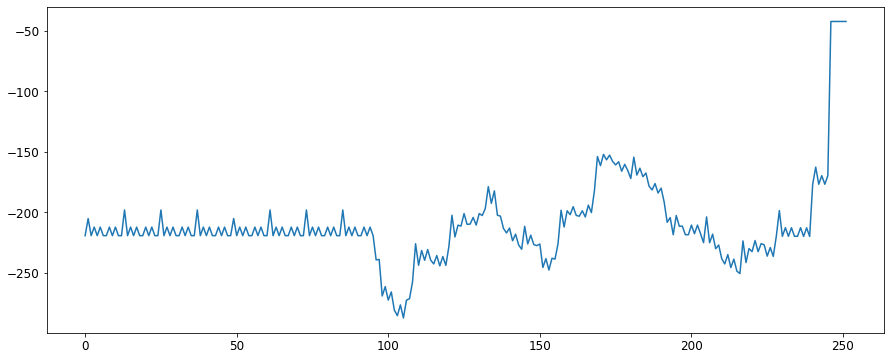

In [70]:
y.plot(figsize=(15, 6))
plt.show()

In [75]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8


# decomposition = sm.tsa.seasonal_decompose(y, model='additive')
# fig = decomposition.plot()
# plt.show()

In [78]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7661      0.397      1.928      0.054      -0.013       1.545
ma.L1         -0.6873      0.424     -1.620      0.105      -1.519       0.144
ar.S.L12      -0.2600      0.109     -2.393      0.017      -0.473      -0.047
sigma2       121.4315      2.401     50.570      0.000     116.725     126.138


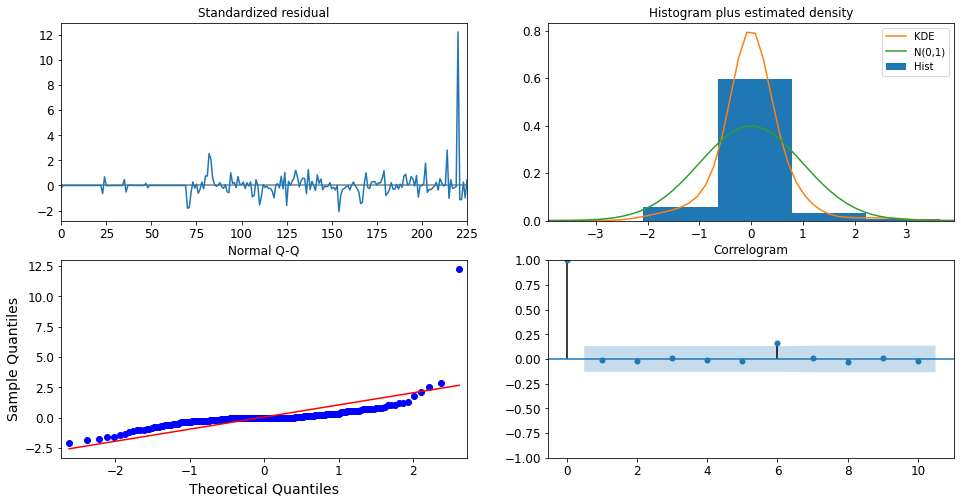

In [79]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [85]:
pred = results.get_prediction(ds=pd.to_datetime('2016-01-01'), dynamic=False)
pred_ci = pred.conf_int()


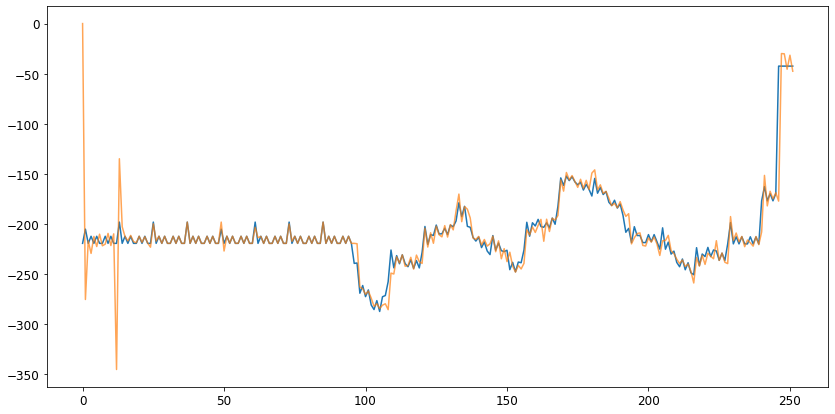

In [92]:
ax = y.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))


In [93]:
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)


In [97]:
pd_0.head()

,ds,y
0,2000-01-01,-219.456097
1,2000-02-01,-205.297639
2,2000-03-01,-219.456097
3,2000-04-01,-212.376868
4,2000-05-01,-219.456097


In [103]:
y_forecasted = pred.predicted_mean
# y_truth = y['2016-01-01':]

pd_0_truth = pd_0.loc[pd_0['ds'] >= '2016-01-01']

# y_truth = pd_0['2016-01-01 00:00:00':]
# date_mask = (pd_0.ds >= '2016-01-01 00:00:00')


# mse = ((y_forecasted - y_truth) ** 2).mean()
# print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
### Check ACF BEFORE FITTING THE MODEL;

### Same as residuals

### Vector (Multivariate) Time Series ARIMA 

In [105]:
y_truth = pd_0_truth['y']

In [107]:
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 362.5


In [108]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 19.04


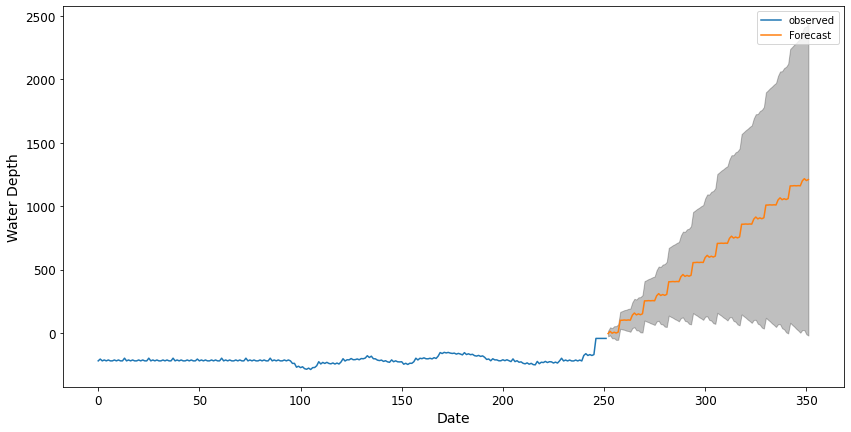

In [110]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Water Depth')
plt.legend()
plt.show()